In [465]:
import numpy as np
import re
from sklearn.metrics import precision_score, recall_score, f1_score

# Cleaning the dataset
def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-z0-9\s]', '', review)  # removing special characters
    review = re.sub(r'\s+', ' ', review).strip()  # removing extra spaces
    return review

# Loading dataset
def load_dataset(file_path):
    import csv
    reviews, sentiments = [], []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            if len(row) != 2:
                continue  # Skip malformed rows
            review, sentiment = row
            reviews.append(clean_review(review))  # to apply cleaning
            sentiments.append(1 if sentiment.strip().lower() == "positive" else 0)
    return reviews, np.array(sentiments)

In [466]:
# Removing duplicated
def preprocess_dataset(file_path):
    # Loading the dataset
    reviews, sentiments = load_dataset(file_path)

    # Removing duplicates
    unique_reviews, unique_indices = np.unique(reviews, return_index=True)
    reviews = np.array(reviews)[unique_indices]
    sentiments = np.array(sentiments)[unique_indices]

    print(f"Number of unique reviews: {len(reviews)}")
    print(f"Number of unique sentiments: {len(sentiments)}")

    return reviews, sentiments

In [467]:
# Spliting the dataset

reviews, sentiments = preprocess_dataset(file_path)
def split_dataset(reviews, sentiments, train_ratio=0.7):
    np.random.seed(42)  # to ensure reproducibility

    # Shuffling indices
    indices = np.arange(len(reviews))
    np.random.shuffle(indices)
    split_idx = int(len(reviews) * train_ratio)

    # Spliting into train and validation sets
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]
    train_reviews = reviews[train_idx]
    train_labels = sentiments[train_idx]
    val_reviews = reviews[val_idx]
    val_labels = sentiments[val_idx]

    # Debugging shapes
    print(f"Initial Shapes - Train Reviews: {train_reviews.shape}, Validation Reviews: {val_reviews.shape}")

    # Ensuring no overlaps
    overlap_indices = np.any(np.isin(val_reviews, train_reviews), axis=1) if val_reviews.ndim > 1 else np.isin(val_reviews, train_reviews)

    # Debugging overlap dimensions
    print(f"overlap_indices shape: {overlap_indices.shape}")
    print(f"val_reviews shape: {val_reviews.shape}")
    print(f"val_labels shape: {val_labels.shape}")

    # Removing overlaps from validation data
    val_reviews = val_reviews[~overlap_indices]
    val_labels = val_labels[~overlap_indices]

    print(f"Overlap After Split: {np.sum(overlap_indices)}")
    return (train_reviews, train_labels), (val_reviews, val_labels)


Number of unique reviews: 49580
Number of unique sentiments: 49580


We decided to use Leaky ReLU in the hidden layers to avoid negative inputs from not contributing and to ensure stable gradient flow, while sigmoid in the output layer enables probability-based predictions. Adam optimization and gradient clipping were implemented to stabilize training and ensure efficient convergence. He initialization, which is typically used for ReLU and it's variants, was applied to weights to prevent vanishing or exploding activations, and dropout regularized the network to improve generalization.


In [468]:
import numpy as np

# Leaky ReLU activation function and its derivative
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

# Sigmoid function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)


class FeedForwardNN:
    def __init__(self, input_size, hidden_size, output_size):
        # He initialization for weights
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1.5 / input_size)
        self.b1 = np.zeros((1, hidden_size))

        self.W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(1.5 / hidden_size)
        self.b2 = np.zeros((1, hidden_size))

        self.W3 = np.random.randn(hidden_size, hidden_size) * np.sqrt(1.5 / hidden_size)
        self.b3 = np.zeros((1, hidden_size))

        self.W4 = np.random.randn(hidden_size, output_size) * np.sqrt(1.5 / hidden_size)
        self.b4 = np.zeros((1, output_size))

        # Adam optimizer state
        self.mW1, self.mW2, self.mW3, self.mW4 = 0, 0, 0, 0
        self.vW1, self.vW2, self.vW3, self.vW4 = 0, 0, 0, 0
        self.mb1, self.mb2, self.mb3, self.mb4 = 0, 0, 0, 0
        self.vb1, self.vb2, self.vb3, self.vb4 = 0, 0, 0, 0
    

    def forward(self, X, keep_prob=1.0):
        # First layer
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = leaky_relu(self.Z1)

        # Apply dropout
        if keep_prob < 1.0:
            self.A1 = self.dropout(self.A1, keep_prob)

        # Second layer
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = leaky_relu(self.Z2)

        # Apply dropout
        if keep_prob < 1.0:
            self.A2 = self.dropout(self.A2, keep_prob)

        # Third layer
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = leaky_relu(self.Z3)

        # Apply dropout
        if keep_prob < 1.0:
            self.A3 = self.dropout(self.A3, keep_prob)

        # Output layer
        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.A4 = sigmoid(self.Z4)
        return self.A4

    def dropout(self, A, keep_prob):
        """
        Apply dropout to activations A using the given keep_prob.
        """
        mask = (np.random.rand(*A.shape) < keep_prob) / keep_prob
        return A * mask

    def backward(self, X, Y, learning_rate, lambda_reg=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1, clip_value=1.0):
        m = X.shape[0]

        # Gradients for output layer
        dZ4 = self.A4 - Y
        dW4 = np.dot(self.A3.T, dZ4) / m + lambda_reg * self.W4
        db4 = np.sum(dZ4, axis=0, keepdims=True) / m
        
        # Clip gradients
        dW4 = np.clip(dW4, -clip_value, clip_value)
        db4 = np.clip(db4, -clip_value, clip_value)


        # Gradients for third hidden layer
        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * leaky_relu_derivative(self.Z3)
        dW3 = np.dot(self.A2.T, dZ3) / m + lambda_reg * self.W3
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m
        
        # Clip gradients
        dW3 = np.clip(dW3, -clip_value, clip_value)
        db3 = np.clip(db3, -clip_value, clip_value)

        # Gradients for second hidden layer
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * leaky_relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m + lambda_reg * self.W2
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
         # Clip gradients
        dW2 = np.clip(dW2, -clip_value, clip_value)
        db2 = np.clip(db2, -clip_value, clip_value)

        # Gradients for first hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * leaky_relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m + lambda_reg * self.W1
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
         # Clip gradients
        dW1 = np.clip(dW1, -clip_value, clip_value)
        db1 = np.clip(db1, -clip_value, clip_value)

        # Update parameters using Adam
        self.mW1, self.vW1, self.W1 = self.adam_update(self.mW1, self.vW1, dW1, self.W1, learning_rate, beta1, beta2, epsilon, t)
        self.mb1, self.vb1, self.b1 = self.adam_update(self.mb1, self.vb1, db1, self.b1, learning_rate, beta1, beta2, epsilon, t)
        self.mW2, self.vW2, self.W2 = self.adam_update(self.mW2, self.vW2, dW2, self.W2, learning_rate, beta1, beta2, epsilon, t)
        self.mb2, self.vb2, self.b2 = self.adam_update(self.mb2, self.vb2, db2, self.b2, learning_rate, beta1, beta2, epsilon, t)
        self.mW3, self.vW3, self.W3 = self.adam_update(self.mW3, self.vW3, dW3, self.W3, learning_rate, beta1, beta2, epsilon, t)
        self.mb3, self.vb3, self.b3 = self.adam_update(self.mb3, self.vb3, db3, self.b3, learning_rate, beta1, beta2, epsilon, t)
        self.mW4, self.vW4, self.W4 = self.adam_update(self.mW4, self.vW4, dW4, self.W4, learning_rate, beta1, beta2, epsilon, t)
        self.mb4, self.vb4, self.b4 = self.adam_update(self.mb4, self.vb4, db4, self.b4, learning_rate, beta1, beta2, epsilon, t)

    def adam_update(self, m, v, grad, param, learning_rate, beta1, beta2, epsilon, t):
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        param -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        return m, v, param


Early stopping was implemented to prevent overfitting

In [469]:
# Early stopping to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


Using GloVe word embeddings, we converted the reviews into numeric embeddings to be passed into our network. These numeric embeddings were normalized and then their sentiments were classified as positive or negative using a probability threshold of 0.5.

In [470]:
def reviews_to_embedding_vectors(reviews, glove_model, embedding_dim):
    vectors = []
    for review in reviews:
        words = review.split()
        word_vectors = [glove_model[word] for word in words if word in glove_model]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))  # Average of word vectors
        else:
            vectors.append(np.zeros(embedding_dim))  # Handle reviews with no known words

    review_vectors = np.array(vectors)

    # Normalize the embeddings
    std = np.std(review_vectors, axis=0)
    std[std == 0] = 1  # Avoid division by zero for features with zero variance
    review_vectors = (review_vectors - np.mean(review_vectors, axis=0)) / std

    # Debug: Check for zero or NaN embeddings
    print(f"Number of zero embeddings: {(review_vectors == 0).all(axis=1).sum()}")
    print(f"Any NaNs in embeddings: {np.isnan(review_vectors).any()}")
    return review_vectors

def predict_with_embeddings(new_reviews, model, glove_model, embedding_dim):
    # Convert new reviews to embedding vectors
    review_vectors = compute_tfidf_weighted_embeddings(new_reviews, glove_model, embedding_dim=embedding_dim)

    # Normalize the embeddings
    std = np.std(review_vectors, axis=0)
    std[std == 0] = 1  # Avoid division by zero for features with zero variance
    review_vectors = (review_vectors - np.mean(review_vectors, axis=0)) / std

    # Get predictions from the model
    predicted_probabilities = model.forward(review_vectors, keep_prob=1.0)  # No dropout during prediction

    # Convert predictions to sentiments
    sentiments = ["positive" if pred >= 0.5 else "negative" for pred in predicted_probabilities.flatten()]
    return sentiments


We then implemented TF-IDF on the embeddngs to help us capture meaningful information in the reviews. 

In [471]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import numpy as np

# Create a custom stop word list
sentimental_stop_words = {"not", "never", "always", "only", "very", "too", "much"}
custom_stop_words_frozenset = ENGLISH_STOP_WORDS - sentimental_stop_words
custom_stop_words = list(custom_stop_words_frozenset) 


# Function to Compute TF-IDF Weighted Embeddings
def compute_tfidf_weighted_embeddings(reviews, glove_model, embedding_dim=100):
    # Compute TF-IDF scores
    vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stop_words)  # limiting to top 5000 features
    tfidf_matrix = vectorizer.fit_transform(reviews)  # TF-IDF scores for all reviews
    tfidf_feature_names = vectorizer.get_feature_names_out()  # vocabulary of TF-IDF

    # Creating a dictionary of TF-IDF scores for each word
    word_to_tfidf = dict(zip(tfidf_feature_names, np.asarray(tfidf_matrix.sum(axis=0)).flatten()))

    # Computing TF-IDF weighted embeddings
    embeddings = []
    for review in reviews:
        words = review.split()
        word_embeddings = []
        weights = []
        for word in words:
            if word in glove_model and word in word_to_tfidf:
                word_embeddings.append(glove_model[word])
                weights.append(word_to_tfidf[word])

        if word_embeddings:
            word_embeddings = np.array(word_embeddings)
            weights = np.array(weights)
            weighted_average = np.average(word_embeddings, axis=0, weights=weights)
            embeddings.append(weighted_average)
        else:
            embeddings.append(np.zeros(embedding_dim))

    return np.array(embeddings)

This training function is where things come together. Here we integrate key processes like dropout, early stopping, and learning rate decay to improve model stability and performance. We also incorporate metrics tracking and visualization for monitoring during training. These processes collectively ensure the model generalizes well to unseen data and avoids common pitfalls like overfitting or class imbalance bias.

In [472]:
def train_with_embeddings(file_path, glove_model, embedding_dim, hidden_size, initial_learning_rate, epochs, batch_size, patience, lambda_reg, train_reviews, train_labels, val_reviews, val_labels):
    # Initializin the model
    input_size = embedding_dim
    output_size = 1
    model = FeedForwardNN(input_size, hidden_size, output_size)

    num_batches = len(train_reviews) // batch_size

    # Initializing early stopping
    early_stopping = EarlyStopping(patience=patience)

    
    # Defining learning rate decay parameters
    initial_learning_rate = 0.001
    decay_rate = 0.0001
    
    # Calculating class weights after splitting data
    # Implementing class weight to prevent bias towards the majority class
    positive_weight = len(train_labels) / np.sum(train_labels)
    class_weight = {0: 1.0, 1: positive_weight}

    # Initializing lists to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []
    
    
    # Training loop
    for epoch in range(epochs):
        # Learning rate decay
        learning_rate = initial_learning_rate / (1 + decay_rate * epoch) # exponential decay
        # Shuffle data at the start of each epoch to prevent memorizing patterns
        indices = np.arange(len(train_reviews))
        np.random.shuffle(indices)
        train_reviews = train_reviews[indices]
        train_labels = train_labels[indices]

        epoch_loss = 0
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            # Get batch data
            batch_reviews = train_reviews[start_idx:end_idx]
            batch_labels = train_labels[start_idx:end_idx]

            # Forward pass
            predictions = model.forward(batch_reviews, keep_prob=0.9)  # 10% dropout to prevent overfitting

            # Class is balanced so no need for class weighted loss function
            # Loss calculations using binary cross-entropy
            loss = -np.mean(
                batch_labels * np.log(np.clip(predictions, 1e-10, 1)) +
                (1 - batch_labels) * np.log(np.clip(1 - predictions, 1e-10, 1))
            )
            epoch_loss += loss


            # Backward pass with L2 regularization
            model.backward(batch_reviews, batch_labels.reshape(-1, 1), learning_rate, lambda_reg)

        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss / num_batches
        train_losses.append(avg_epoch_loss)

        # Validate the model
        val_predictions = model.forward(val_reviews, keep_prob=1).flatten()  # no dropout during validation
        val_predictions_binary = (val_predictions >= 0.5).astype(int)
        
        # Calculating metrics
        val_accuracy = np.mean(val_predictions_binary == val_labels)
        val_precision = precision_score(val_labels, val_predictions_binary)
        val_recall = recall_score(val_labels, val_predictions_binary)
        val_f1 = f1_score(val_labels, val_predictions_binary)

        # Calculate validation loss
        val_loss = -np.mean(
            val_labels * np.log(np.clip(val_predictions, 1e-10, 1)) +
            (1 - val_labels) * np.log(np.clip(1 - val_predictions, 1e-10, 1))
        )
        val_losses.append(val_loss)
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

        # Print loss and accuracy every 50 epochs
        if epoch % 50 == 0 or epoch == epochs - 1:
            print(
                f"Epoch {epoch}, Average Train Loss: {avg_epoch_loss:.4f}, "
                f"Validation Loss: {val_loss:.4f}, "
                f"Validation Accuracy: {val_accuracy:.4f}, "
                f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, "
                f"F1-Score: {val_f1:.4f}"
            )

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # Final validation evaluation
    print(
        f"Final Validation Accuracy: {val_accuracy:.4f}, "
        f"Precision: {val_precisions[-1]:.4f}, "
        f"Recall: {val_recalls[-1]:.4f}, F1-Score: {val_f1_scores[-1]:.4f}"
    )

    # Plotting metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Visualisation function for the loss curves and validation metrics
    
    def plot_metrics(metrics_dict, ylabel='Value', title='Metrics Over Epochs', colors=None):
        plt.figure(figsize=(8, 5))
        for i, (metric_name, metric_values) in enumerate(metrics_dict.items()):
            if colors:
                if isinstance(colors, dict):
                    color = colors.get(metric_name, None)  # Use the color if specified in the dict
                else:
                    color = colors[i % len(colors)]  # Cycle through the colors list
            else:
                color = None  # Default color

            plt.plot(metric_values, label=metric_name, color=color, linewidth=2)

        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(alpha=0.5, linestyle='--')
        plt.tight_layout()
        plt.show()
              

    # Plotting training and validation loss
    metrics_dict = {
    'Train Loss': train_losses,
    'Validation Loss': val_losses
    }

    colors = {'Train Loss': 'tab:cyan', 'Validation Loss': 'tab:orange'}

    plot_metrics(metrics_dict, ylabel='Loss', title='Train and Validation Loss Over Epochs', colors=colors)

    # Plotting validation metrics
    metrics_dict2 = {
    'Validation Precision': val_precisions,
    'Validation Recall': val_recalls,
    'Validation F1-Score': val_f1_scores
    }

    colors = ['tab:blue', 'tab:purple', 'tab:red']

    plot_metrics(metrics_dict2, ylabel='Metrics', title='Validation Metrics Over Epochs', colors=colors)
 
    return model, glove_model, train_reviews, train_labels, val_reviews, val_labels

In [425]:
from gensim.downloader import load

# Loading and caching 100-dimensional GloVe vectors
glove_model = load("glove-wiki-gigaword-100") 

# Making sure it worked and checking embedding dimensionality
print(glove_model["movie"])  # Vector for the word "movie"
print(len(glove_model["movie"]))  # Should print 100

[ 0.38251    0.14821    0.60601   -0.51533    0.43992    0.061053
 -0.62716   -0.025385   0.1643    -0.22101    0.14423   -0.37213
 -0.21683   -0.08895    0.097904   0.6561     0.64455    0.47698
  0.83849    1.6486     0.88922   -0.1181    -0.012465  -0.52082
  0.77854    0.48723   -0.014991  -0.14127   -0.34747   -0.29595
  0.1028     0.57191   -0.045594   0.026443   0.53816    0.32257
  0.40788   -0.043599  -0.146     -0.48346    0.32036    0.55086
 -0.76259    0.43269    0.61753   -0.36503   -0.60599   -0.79615
  0.3929    -0.23668   -0.34719   -0.61201    0.54747    0.94812
  0.20941   -2.7771    -0.6022     0.8495     1.2549     0.017893
 -0.041901   2.1147    -0.026618  -0.28104    0.68124   -0.14165
  0.99249    0.49879   -0.67538    0.6417     0.42303   -0.27913
  0.063403   0.68909   -0.36183    0.053709  -0.16806    0.19422
 -0.47073   -0.14803   -0.58986   -0.2797     0.16792    0.10568
 -1.7601     0.0088254 -0.83326   -0.5836    -0.37079   -0.56591
  0.20699    0.071315  

Putting everything together gives us our pipeline:

Number of unique reviews: 49580
Number of unique sentiments: 49580
Initial Shapes - Train Reviews: (34706, 100), Validation Reviews: (14874, 100)
overlap_indices shape: (14874,)
val_reviews shape: (14874, 100)
val_labels shape: (14874,)
Overlap After Split: 3
Train Reviews Shape: (34706, 100)
Validation Reviews Shape: (14871, 100)
Train Labels Shape: (34706,)
Validation Labels Shape: (14871,)
Epoch 0, Average Train Loss: 0.7745, Validation Loss: 0.5729, Validation Accuracy: 0.6926, Precision: 0.8097, Recall: 0.5191, F1-Score: 0.6326
Epoch 50, Average Train Loss: 0.9580, Validation Loss: 0.4813, Validation Accuracy: 0.7710, Precision: 0.7572, Recall: 0.8108, F1-Score: 0.7831
Epoch 100, Average Train Loss: 0.9770, Validation Loss: 0.4751, Validation Accuracy: 0.7772, Precision: 0.7588, Recall: 0.8254, F1-Score: 0.7907
Early stopping triggered at epoch 113
Final Validation Accuracy: 0.7768, Precision: 0.7733, Recall: 0.7954, F1-Score: 0.7842


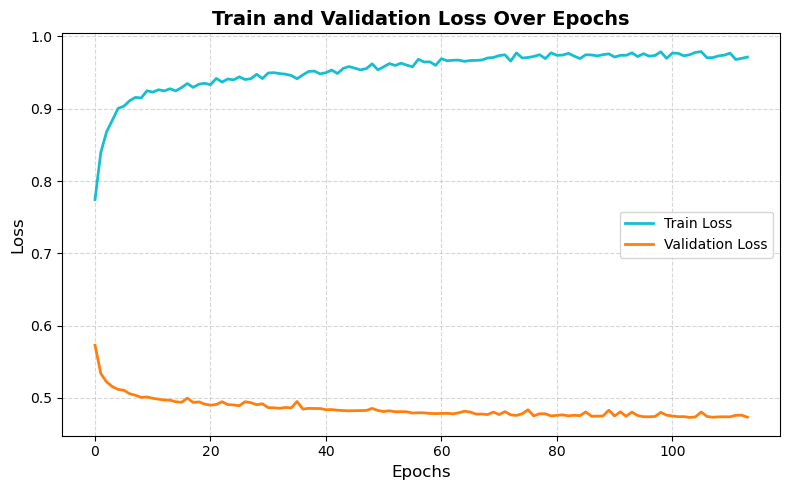

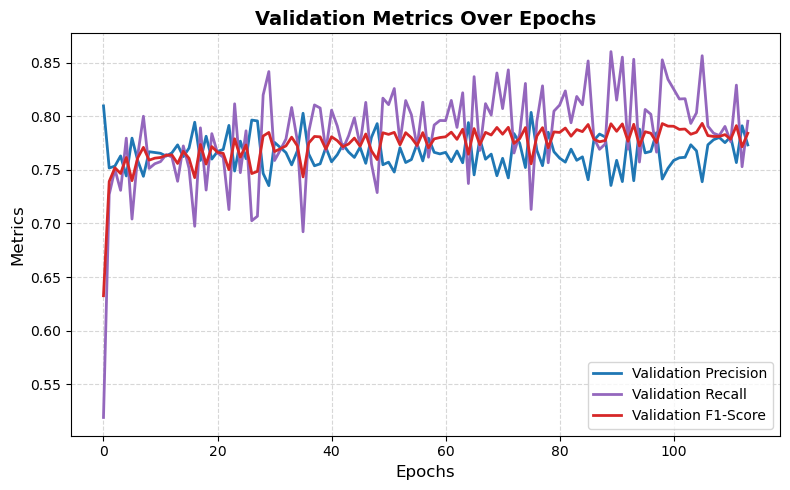

In [473]:
# Train the model
file_path = "C:/Users/naabe/Documents/text_mining/Assignment_2/IMDB_Dataset.csv"

# 1. Data preprocessing
reviews, sentiments = preprocess_dataset(file_path)

# Removing duplicates
unique_reviews, unique_indices = np.unique(reviews, return_index=True)
reviews = np.array(reviews)[unique_indices]
sentiments = np.array(sentiments)[unique_indices]

# 2. Converting reviews to embeddings
review_vectors = compute_tfidf_weighted_embeddings(reviews, glove_model, embedding_dim=100)

# 3. Spliting the dataset into training and validation sets
(train_reviews, train_labels), (val_reviews, val_labels) = split_dataset(review_vectors, sentiments, train_ratio=0.7)

# Debugging to verify our shapes
print("Train Reviews Shape:", train_reviews.shape)  # Should be (num_samples_train, embedding_dim)
print("Validation Reviews Shape:", val_reviews.shape)  # Should be (num_samples_val, embedding_dim)
print("Train Labels Shape:", train_labels.shape)  # Should be (num_samples_train,)
print("Validation Labels Shape:", val_labels.shape)  # Should be (num_samples_val,)

# 4. Training the model
model, glove_model, train_reviews, train_labels, val_reviews, val_labels = train_with_embeddings(
    file_path,
    glove_model,
    embedding_dim=100, 
    hidden_size=35,
    initial_learning_rate=0.0001,
    epochs=500,
    batch_size=150,
    patience=10,
    lambda_reg=0.001,
    train_reviews=train_reviews,
    train_labels=train_labels,
    val_reviews=val_reviews,
    val_labels=val_labels
)


# Conclusions

We can see that our average training loss tends to increase from epoch to epoch which is unusual. To combat this, we tried changing parts of our activation function from ReLU to leaky ReLU and also to match the drop out rate applied during the training to the validation process. However, this didn't really help with the increasing trend in the training loss. What has helped the most has been implementing the leaky ReLU activation function, reducing our learning rate to 0.0001, decreasing our batch size and setting the number of neurons in each hidden layer to 35. Setting our learning rate quite low helps us prevent instability in the training loss. 

Nonetheless, the decreasing validation loss shows that the model is learning and generalizing well so the increase in training loss overtime can be overlooked. 

When we look at the plot with our precision, recall and F1-score, we can see that they all fluctuate heavily initially but stabilize as the training progresses. The final recall of 79.5% suggests that most of the true positives are identified by the network. A precision of 77.3% indicates that the model is reliable. Our F1-score being 78.4%, tells us that the model strikes a good balance between predicting true positives and avoiding false positives.

# Bibliography

ChatGPT. (2024) “Sentiment Analysis Debug.” Chat conversation.

Brownlee, J. (2021, January 13). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. Machine Learning Mastery. https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/


Rokon, O. F. (2024, June 14). Most Popular Activation Functions in Neural Networks: A Comprehensive Guide. Medium. https://medium.com/@mroko001/most-popular-activation-functions-in-neural-networks-a-comprehensive-guide-6ec0952f87cd


Pennington et al,. (2014). GloVe: Global Vectors for Word Representation 

In [476]:
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def compute_word_sentiment_scores(reviews, sentiments):
    word_scores = defaultdict(lambda: [0, 0])  # [positive_count, negative_count]
    
    for review, sentiment in zip(reviews, sentiments):
        words = review.split()
        for word in words:
            if sentiment == 1:  # Positive review
                word_scores[word][0] += 1
            else:  # Negative review
                word_scores[word][1] += 1
    
    # Calculate sentiment association scores
    word_sentiment_scores = {
        word: (counts[0] - counts[1])  # Positive count - Negative count
        for word, counts in word_scores.items()
    }
    return word_sentiment_scores

In [477]:
word_sentiment_scores = compute_word_sentiment_scores(reviews, sentiments)


In [478]:
def get_top_words(word_scores, top_n=20, most_positive=True):
    sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=most_positive)
    return sorted_words[:top_n]

def visualize_top_words(top_words, title="Top Words"):
    import matplotlib.pyplot as plt
    words, scores = zip(*top_words)
    plt.figure(figsize=(10, 6))
    plt.barh(words, scores, color='tab:blue' if title == "Most Positive Words" else 'tab:red')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Words')
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest score at the top
    plt.show()
    
def create_wordcloud(word_sentiment_scores, title="Word Cloud"):
    wordcloud = WordCloud(
        background_color='white',
        colormap='coolwarm',
        width=800,
        height=400
    ).generate_from_frequencies(word_sentiment_scores)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()


Number of unique reviews: 49580
Number of unique sentiments: 49580


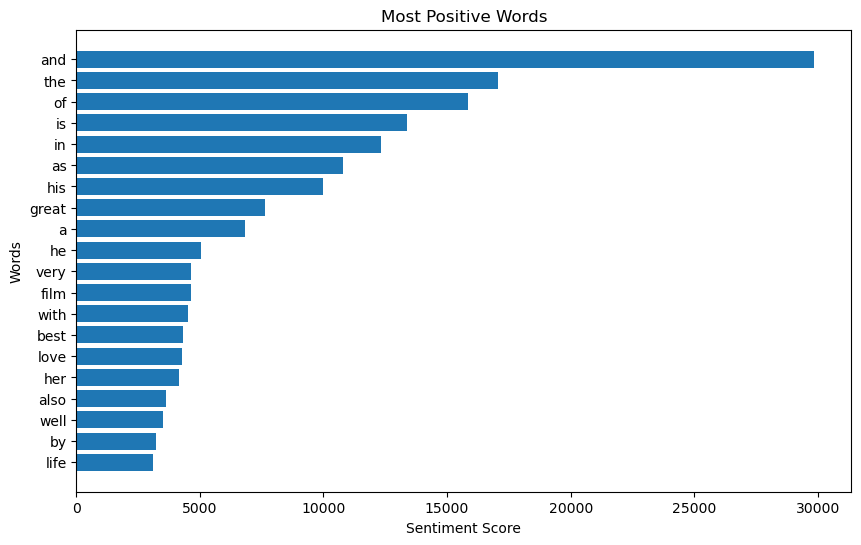

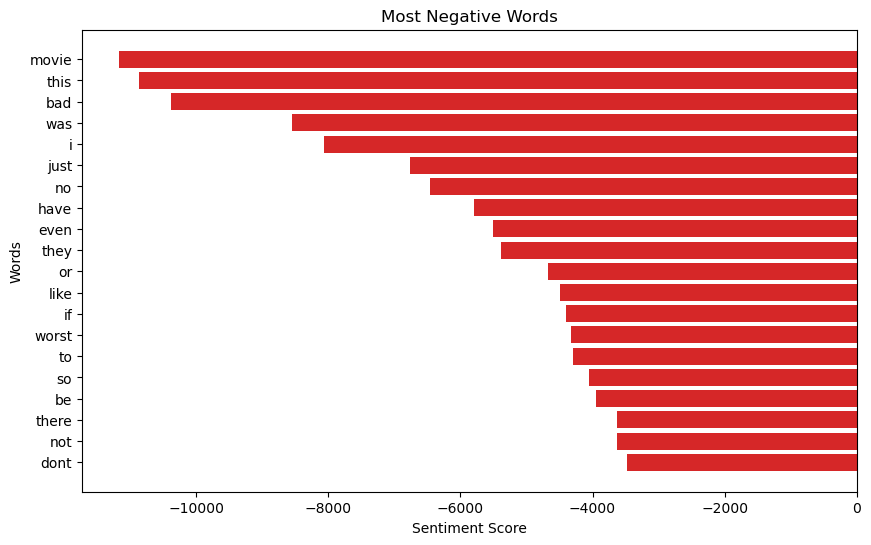

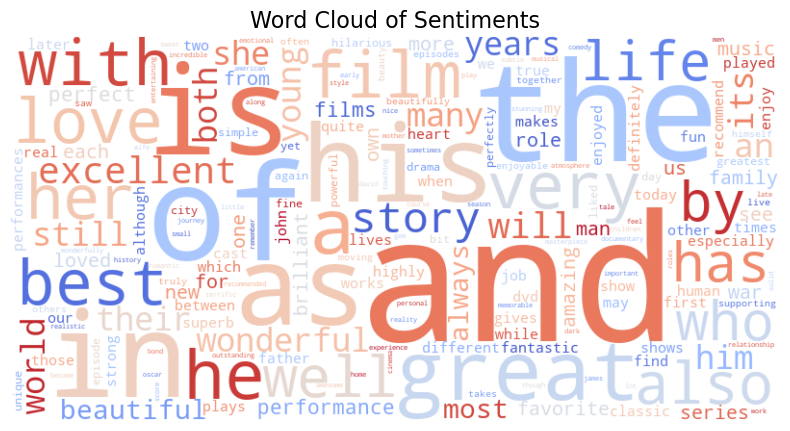

In [480]:
# Step 1: Preprocess Reviews
preprocessed_reviews = preprocess_dataset(file_path)[0]  # Assuming your function returns (reviews, sentiments)

# Step 2: Compute Word Sentiment Scores
word_sentiment_scores = compute_word_sentiment_scores(preprocessed_reviews, sentiments)

# Get the most positive and negative words
top_positive_words = get_top_words(word_sentiment_scores, top_n=20, most_positive=True)
top_negative_words = get_top_words(word_sentiment_scores, top_n=20, most_positive=False)

# Visualize the top positive words
visualize_top_words(top_positive_words, title="Most Positive Words")

# Visualize the top negative words
visualize_top_words(top_negative_words, title="Most Negative Words")

# Create a word cloud for the entire vocabulary
create_wordcloud(word_sentiment_scores, title="Word Cloud of Sentiments")
